In [1]:
import pandas as pd
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
from adjustText import adjust_text

import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

# Load unseen-species model data
#path = 'unseen_species_model/unseen_species_model.csv'
#path = 'unseen_species_model/unseen_species_model_no_occupation.csv'
path = 'unseen_species_model/unseen_species_model_bayesian.csv'


df_cultura_original = pd.read_csv(path, index_col = [0])
df_cultura_original

individual_wikidata_id  decade          region_name  count_works  \
0                    Q1000034    1850         German world          0.0   
2                    Q1000034    1850  Northwestern Europe          0.0   
5                  Q100022441    1770               France          0.0   
6                  Q100022441    1770  Northwestern Europe          0.0   
9                  Q100028706    1880                Italy          0.0   
...                       ...     ...                  ...          ...   
474175              Q99982212    1880       Central Europe          0.0   
474181                Q999920    1790         German world          2.0   
474182                Q999920    1790  Northwestern Europe          2.0   
474184                Q999983    1340               France          0.0   
474185                Q999983    1340  Northwestern Europe          0.0   

               occupation  century  count  y    y_mean     y_min     y_max  \
0                  Writer     1800    0.0  0  0.026322  0.025143  0.027497   
2                  Writer     1800    0.0  0  0.039378  0.038297  0.040462   
5       Performing Artist     1800    0.0  0  0.043535  0.039614  0.047476   
6       Performing Artist     1800    0.0  0  0.035473  0.032444  0.038573   
9                Musician     1900    0.0  0  0.004629  0.004096  0.005170   
...                   ...      ...    ... ..       ...       ...       ...   
474175          Architect     1900    0.0  0  0.012460  0.011082  0.013919   
474181            Painter     1800    2.0  1  0.069045  0.066096  0.072048   
474182            Painter     1800    2.0  1  0.101092  0.098283  0.103914   
474184             Writer     1300    0.0  0  0.071291  0.065518  0.077156   
474185             Writer     1300    0.0  0  0.058405  0.053853  0.062919   

                f0      max_f0     min_f0  f1  f2  
0        18.008463   18.898832  17.197598   1   0  
2        11.717243   12.074992  11.377598   1   0  
5        10.506729   11.641732   9.555465   1   0  
6        13.113081   14.427312  11.981839   1   0  
9       107.026430  121.076616  95.720245   1   0  
...            ...         ...        ...  ..  ..  
474175   39.133367   44.122022  34.928435   1   0  
474181    6.276144    6.597781   5.975854   0   1  
474182    3.996555    4.136472   3.863650   0   1  
474184    6.049192    6.664265   5.518959   1   0  
474185    7.590141    8.311455   6.978209   1   0  

[201243 rows x 16 columns]

In [2]:

#df_cultura_original = df_cultura_original.rename(columns = {'f0_min':'min_f0', 'f0_max':'max_f0'})

df_cultura_original['N_est'] = df_cultura_original['f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual
df_cultura_original['N_est_min']  =  df_cultura_original['min_f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual
df_cultura_original['N_est_max']  =  df_cultura_original['max_f0'] + df_cultura_original['f1'] + df_cultura_original['f2']# plus the individual

df_cultura = df_cultura_original.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

# Load individuals Data
df_individuals = pd.read_csv('db_extract/df_individuals_score.csv', index_col = [0])
#df_individuals = df_individuals[df_individuals['individual_wikidata_id'].isin(list(df_cultura_original['individual_wikidata_id']))]



# Add indiviudals not taken into account into the unseen-species model
df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
df_cultura = df_cultura.fillna(0)


df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']

# Define a function to rename regions
def rename_region(region):
    if region in ['Arabic world', 'Persian world']:
        return 'MENA'
    else:
        return 'Other'


# ADD MENA
new_df = df_cultura.copy()
# Apply the function to create a new 'Region Group' column
new_df['region_name'] = new_df['region_name'].apply(rename_region)

# Group by the new 'Region Group' and 'decade' columns, then sum the other columns
new_df = new_df.groupby(['region_name', 'decade']).sum().reset_index()

# Now concatenate the aggregated data back to the original dataset
df_cultura = pd.concat([new_df, df_cultura], ignore_index=True)


df_individuals_bis = df_individuals.copy()
df_individuals_bis['region_name']=df_individuals_bis['region_name'].apply(rename_region)
df_individuals = pd.concat([df_individuals, df_individuals_bis], ignore_index=True)

In [3]:
#df_cultura.to_csv('unseen_species_model/estimates.csv')

In [4]:
list(set(df_individuals.region_name))

['East Slavic',
 'Arabian peninsula',
 'Oceania',
 'Nordic countries',
 'MENA',
 'Southern India',
 'South East Asia',
 'Muslim world',
 'Switzerland',
 'Northern Japan',
 'Eastern Europe',
 'United Kingdom',
 'Balkans',
 'Greek World',
 'Italy',
 'Persian world',
 'Northern India',
 'Greece',
 'Ottoman world',
 'Northern France',
 'Southern Japan',
 'Spain',
 'Arabic world',
 'mediterranean World',
 'Latin World',
 'Southwestern Europe',
 'Portugal',
 'Germany',
 'Northern China',
 'Western Europe',
 'France',
 'Japan',
 'Northwestern Europe',
 'Slav world',
 'Southern France',
 'Ottoman Turkey',
 'British Islands',
 'Southern Italy',
 'South America',
 'Indian world',
 'Iceland',
 'Central Europe',
 'German world',
 'Netherlands',
 'Belgium',
 'Yangtze',
 'Africa',
 'Ireland',
 'Other',
 'Low countries',
 'Austria',
 'Norway',
 'North America',
 'Central America',
 'Sweden',
 'Chinese world',
 'Korea',
 'Southern China',
 'Denmark',
 'Finland',
 'Northern Italy']

### Make function

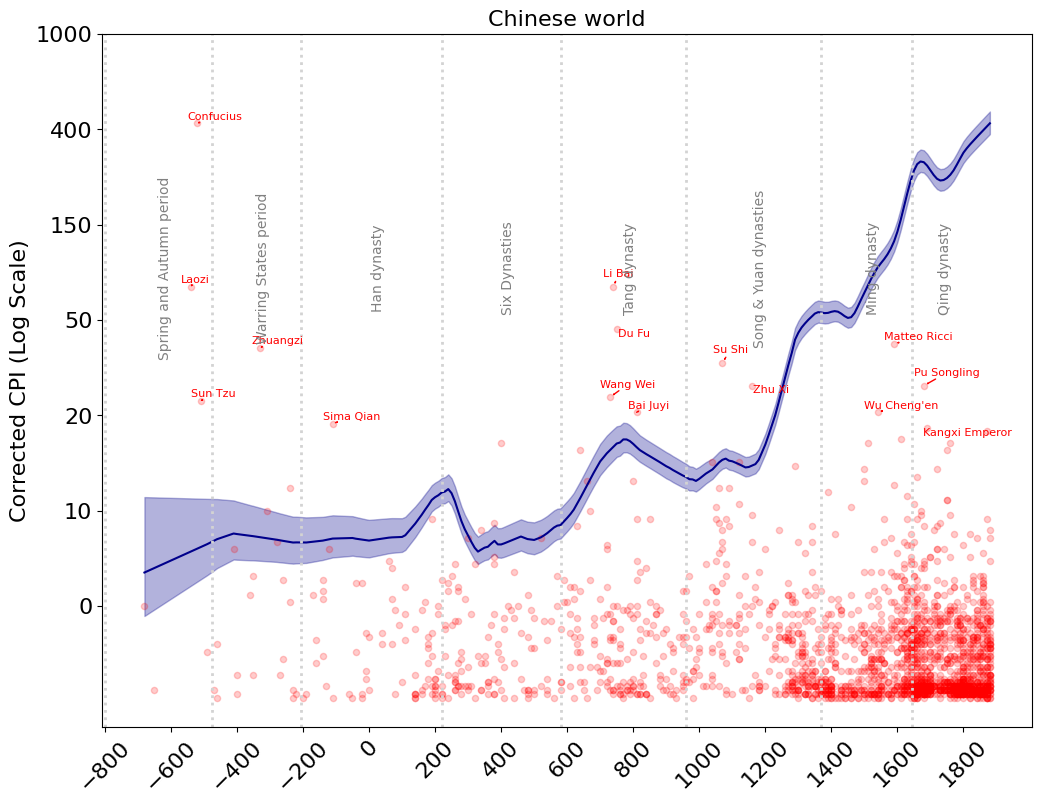

In [5]:
# Define a custom rounding function
def custom_round(x):
    if x >= 100000:
        return np.round(x, -5)  # Round to nearest 100000
    elif x >= 10000:
        return np.round(x, -4)  # Round to nearest 10000
    elif x >= 1000:
        return np.round(x, -3)  # Round to nearest 1000
    else:
        return np.round(x, -1)  # Round to nearest 10


def plot_figure(region_name, 
                max_year, 
                min_year, 
                period_data, 
                year_step = 200, 
                plot_names = True, 
                frac = 0.1, 
                top_n_individuals = 15,
                plot_bars = False,
                plot_original_trend = False,
                yticks = [5, 10, 50, 100, 500, 1000, 2000],
                fifty = False,
                log=True,
                legend=False,
                plot_name_names=True,
                fontsize_title=16,
                fontsize_axis_ticks = 16,
                fontsize_axis_name = 16):


    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name])]
        

    df = df_cultura[df_cultura['region_name'].isin([region_name])]

    if fifty:
            df['decade'] = df['decade'].apply(lambda x: int(x) + (50 - int(x) % 50))
            df = df.groupby(['region_name', 'decade']).sum().reset_index()



    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]

    if log:
        df['N_est'] = np.log(df['N_est'])  # Applying log transformation
        df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
        df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
        df['score'] = np.log(df['score'])  # Max bound log

    # Define your color scheme
    colors = {
        region_name: "#00008b",
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = sm.nonparametric.lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = sm.nonparametric.lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = sm.nonparametric.lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label ='Corrected Index', color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing

            smoothed = sm.nonparametric.lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)
            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label='Original Index', color='#006400', linewidth=3, linestyle='-')



    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color='red', alpha=0.2, s=20)


            if plot_name_names:

                # Texts for top 15
                for _, row in top_individuals.iterrows():
                    score_normalized = (row['score'] / max_global_score) * max_n_est
                    text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                                ha='center', va='bottom', color='red',fontsize=8)
                    texts.append(text)

                # Use adjust_text for the current region with the corresponding arrow color
                adjust_text(texts, arrowprops=dict(arrowstyle="->", color="red"))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.1, zorder=2)


   
    yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    # ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    # ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels

    # Get current y-axis ticks (which are in log scale)


    if log:
        ticks_log = ax.get_yticks()

        # Calculate the original values from the log scale ticks
        ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

        # Round to the nearest 10

        ticks_rounded = [custom_round(tick) for tick in ticks_original]

        #ticks_rounded = np.around(ticks_original / 10) * 10

        # Remove duplicates, keeping only the last occurrence
        unique_ticks = {}
        for tick, original in zip(ticks_rounded, ticks_log):
            unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

        # Now, set the ticks and labels, skipping duplicates
        final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
        ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
        ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels



    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=fontsize_axis_ticks)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=fontsize_axis_ticks)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    if log:
        ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = fontsize_axis_name)
    else:
         ax.set_ylabel('Corrected CPI', fontsize = fontsize_axis_name)
    ax.set_title(region_name, fontsize = fontsize_title)
    
    if plot_original_trend:
        ax.legend()  # This will add the legend with labels as specified in plot commands
    else:
        ax.legend().remove()  # This conditionally removes the legend
    
    plt.show()


region_name = 'Chinese world'
min_year = -800
max_year = 1880


chinese_period_data = {
    "x_intercepts": [
        [-800, -476],
        [-476, -206],
        [-206, 220],
        [220, 581],
        [581, 960],
        [960, 1368],
        [1368, 1644],
        [1644, 1800]
    ],
    "labels": [
        "Spring and Autumn period",
        "Warring States period",
        "Han dynasty",
        "Six Dynasties",
        "Tang dynasty",
        "Song & Yuan dynasties",
        "Ming dynasty",
        "Qing dynasty"
    ]
}


plot_figure(region_name, max_year, min_year, period_data=chinese_period_data, year_step = 200, plot_original_trend = False, fifty=False, frac=0.1)



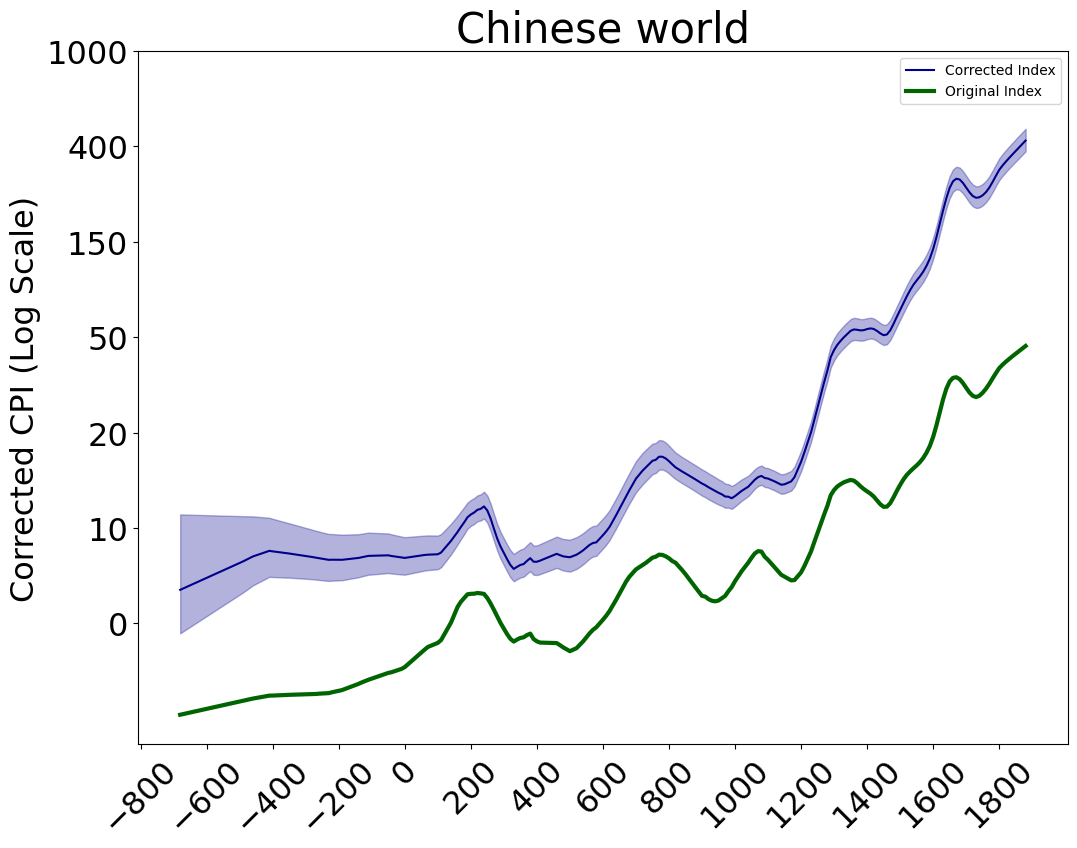

In [6]:
plot_figure(region_name, max_year, min_year, period_data=None, 
            year_step = 200, plot_original_trend = True, fifty=False, 
            frac=0.1, plot_name_names=False, plot_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

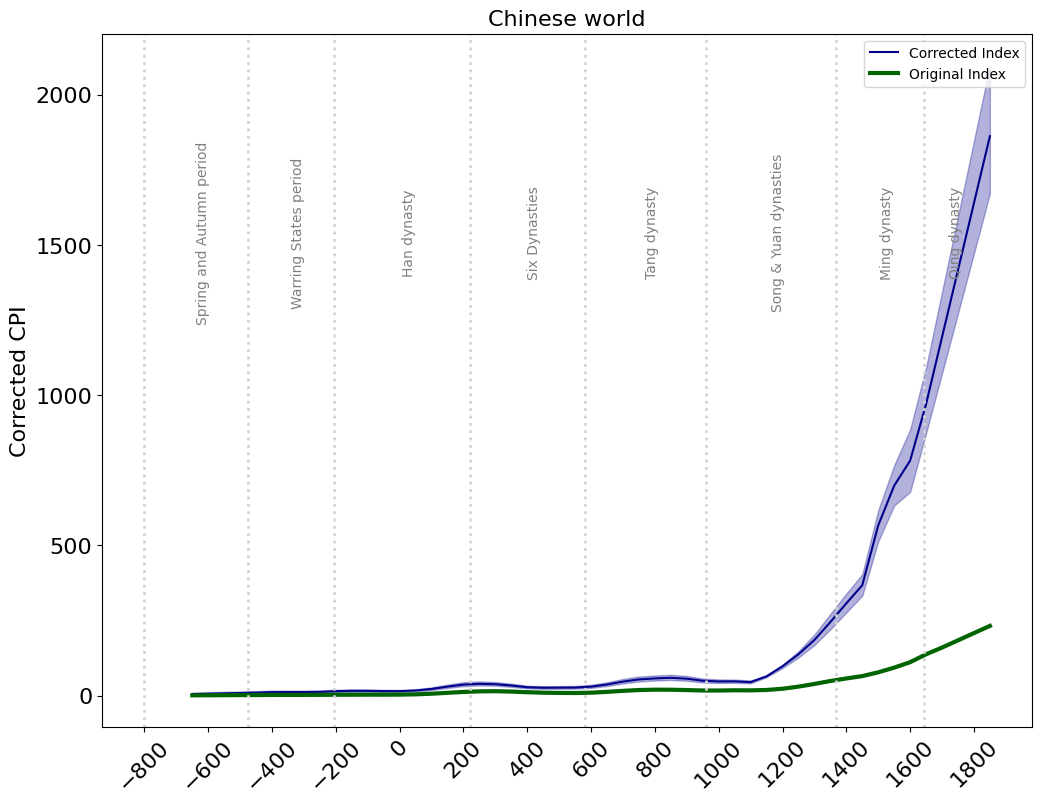

In [7]:
plot_figure(region_name, max_year, min_year,
             period_data=chinese_period_data, 
             year_step = 200, 
             plot_original_trend = True, fifty=True, frac=0.2, plot_names = False, log=False, legend=True)


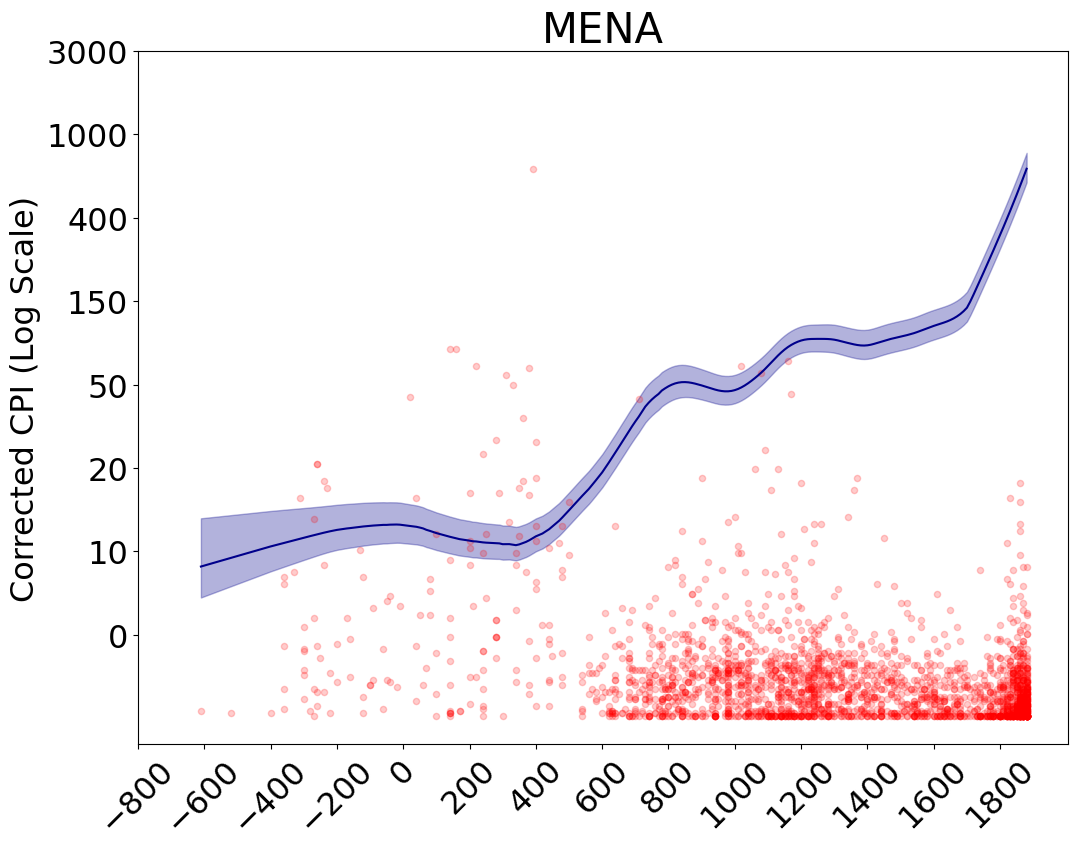

In [8]:
plot_figure(region_name = 'MENA', min_year = -800, 
            max_year = 1880, period_data = None,  year_step = 200, frac=0.2, 
            plot_bars = False, plot_original_trend = False, fifty=False, plot_name_names = False,
             fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

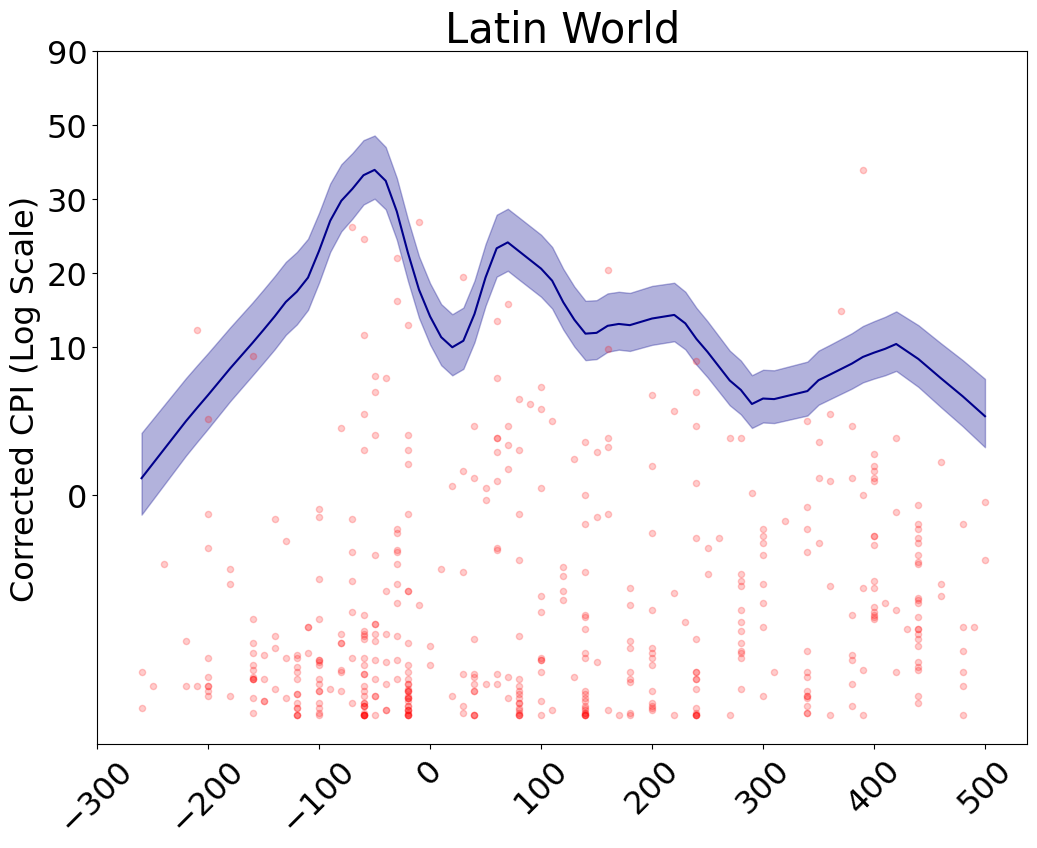

In [9]:
plot_figure(region_name = 'Latin World', min_year = -300, 
            max_year = 500, period_data = None,  year_step = 100, frac=0.2, 
            plot_bars = False, plot_original_trend = False, fifty=False, plot_name_names = False,
             fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

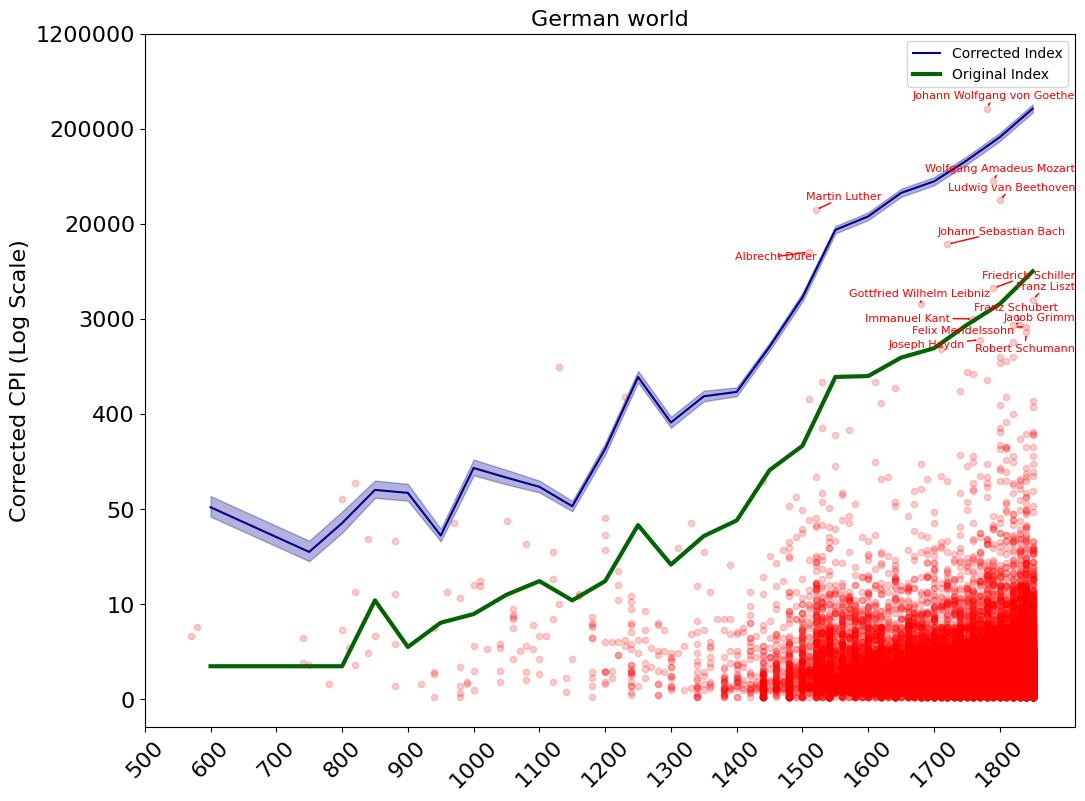

In [10]:
plot_figure(region_name = 'German world', min_year = 500, 
            max_year = 1850, period_data = None,  year_step = 100, frac=0.15, plot_bars = False, plot_original_trend = True, fifty=True)

In [11]:
list(set(df_cultura['region_name']))

['East Slavic',
 'MENA',
 'Nordic countries',
 'Northern Japan',
 'United Kingdom',
 'Greek World',
 'Italy',
 'Persian world',
 'Southern Japan',
 'Spain',
 'Arabic world',
 'Latin World',
 'Portugal',
 'Southwestern Europe',
 'Northern China',
 'France',
 'Japan',
 'Northwestern Europe',
 'Indian world',
 'Central Europe',
 'German world',
 'Other',
 'Low countries',
 'Chinese world',
 'Korea',
 'Southern China']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx an

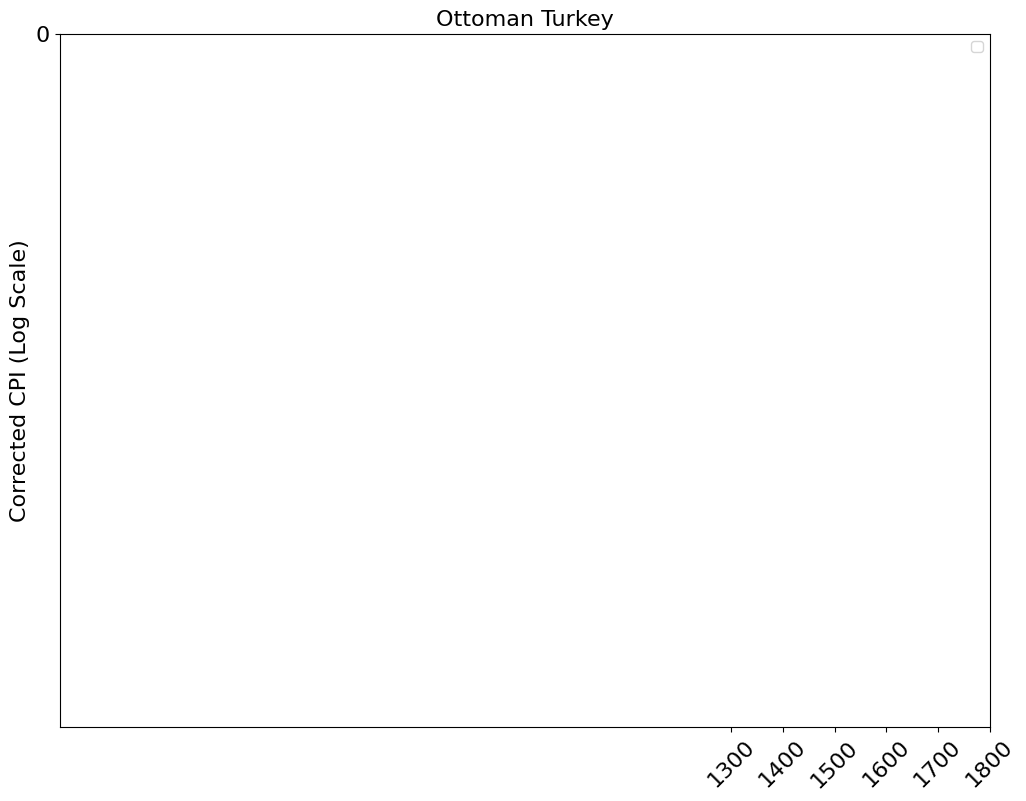

In [12]:
plot_figure(region_name = 'Ottoman Turkey', min_year = 1300, 
            max_year = 1850, period_data = None,  year_step = 100, frac=0.2, plot_bars = False, plot_original_trend = True, fifty=True)

In [13]:
df_individuals[df_individuals['region_name']=='Nordic countries'].sort_values('decade')

individual_wikidata_id  productive_year  decade  \
77787                Q1402591            586.0     590   
100560              Q15661609            829.0     830   
246074               Q2628262            845.0     840   
228818               Q2367169            835.0     840   
123608              Q16782546            853.0     850   
...                       ...              ...     ...   
474454               Q6228296           1884.0    1880   
474451               Q6228261           1881.0    1880   
121120              Q16650323           1880.0    1880   
296343              Q31684815           1883.0    1880   
475130               Q6236460           1875.0    1880   

                   individual_name  score       region_name  
77787                      Ohthere      3  Nordic countries  
100560       Brúni hvíti Háreksson      1  Nordic countries  
246074                     Hastein      5  Nordic countries  
228818              Bragi Boddason     13  Nordic countries  
123608       Þórólfur Þorsteinsson      1  Nordic countries  
...                            ...    ...               ...  
474454                  Jonas Wærn      2  Nordic countries  
474451         Thorsten Waenerberg     10  Nordic countries  
121120               Nils Selander     10  Nordic countries  
296343  Alfvar Theodorik Segerdahl      1  Nordic countries  
475130         Per Emanuel Werming      2  Nordic countries  

[8254 rows x 6 columns]

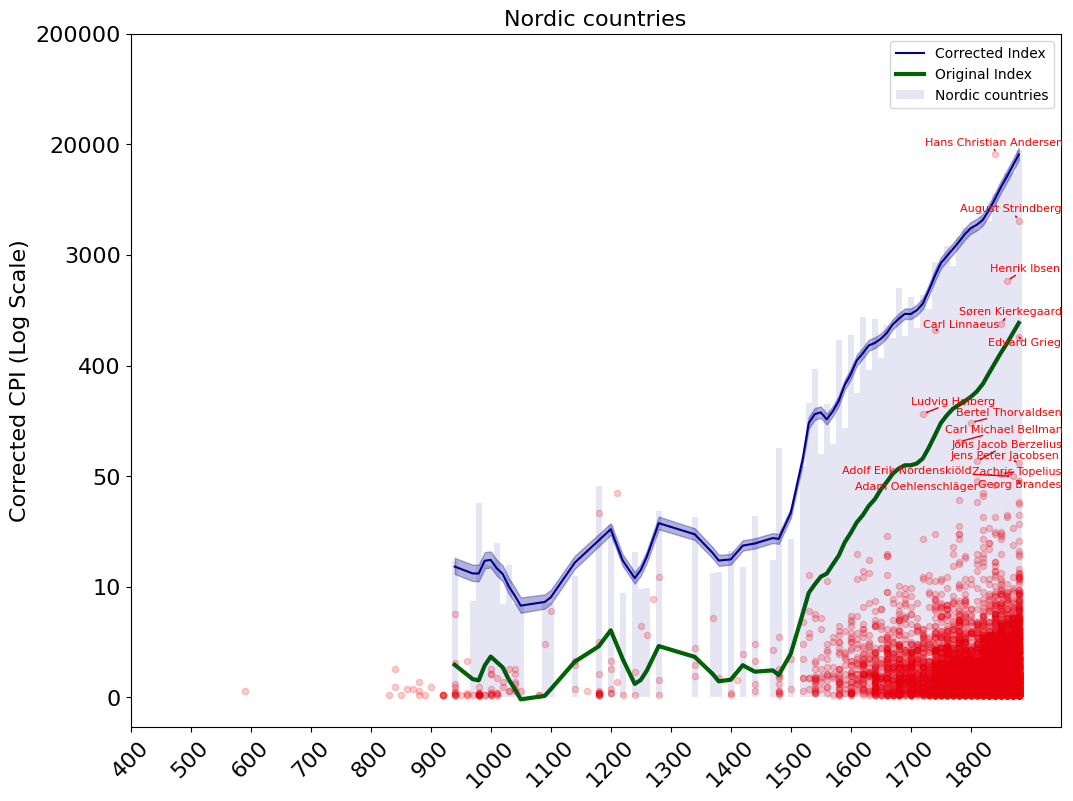

In [14]:
plot_figure(region_name = 'Nordic countries', min_year = 400, max_year = 1880,period_data = None,  year_step = 100, frac=0.1, plot_bars = True,  plot_original_trend = True,)

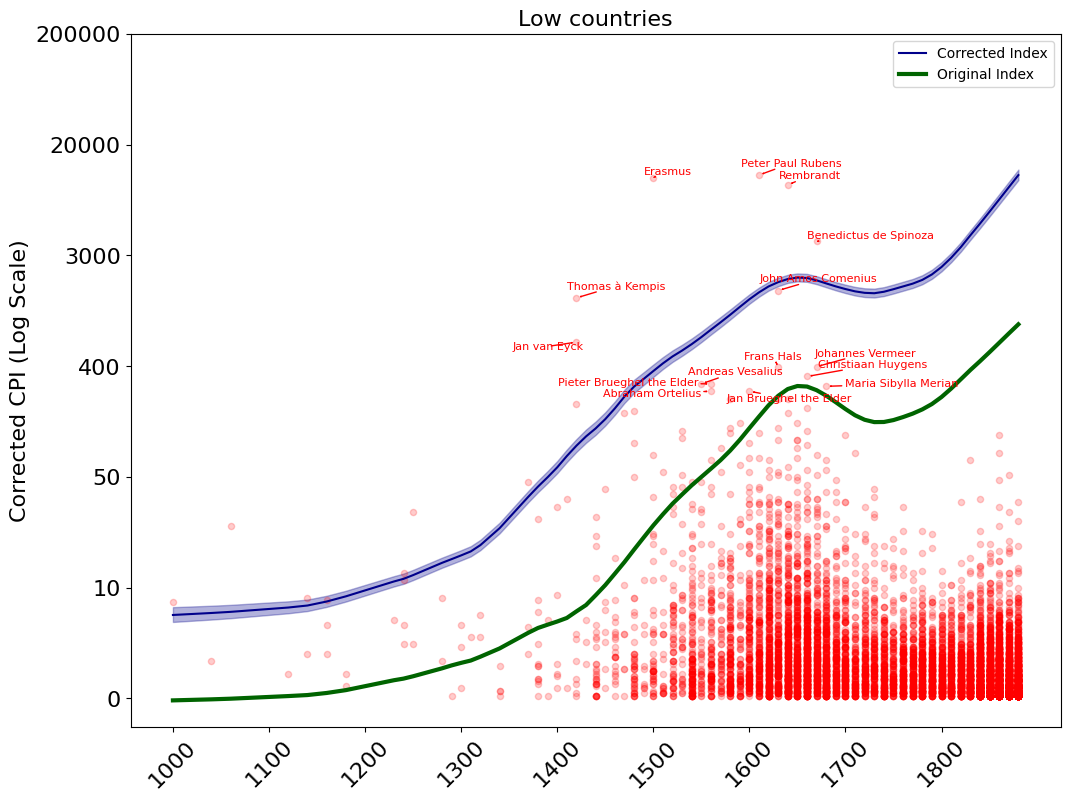

In [15]:
plot_figure(region_name = 'Low countries', min_year = 1000, max_year = 1880,period_data = None,  year_step = 100, frac=0.2,  plot_original_trend = True,
             yticks = [5, 10, 50, 100, 500, 1000, 2000, 5000, 10000, 20000])

In [16]:
list(set(df_cultura.region_name))

['East Slavic',
 'MENA',
 'Nordic countries',
 'Northern Japan',
 'United Kingdom',
 'Greek World',
 'Italy',
 'Persian world',
 'Southern Japan',
 'Spain',
 'Arabic world',
 'Latin World',
 'Portugal',
 'Southwestern Europe',
 'Northern China',
 'France',
 'Japan',
 'Northwestern Europe',
 'Indian world',
 'Central Europe',
 'German world',
 'Other',
 'Low countries',
 'Chinese world',
 'Korea',
 'Southern China']

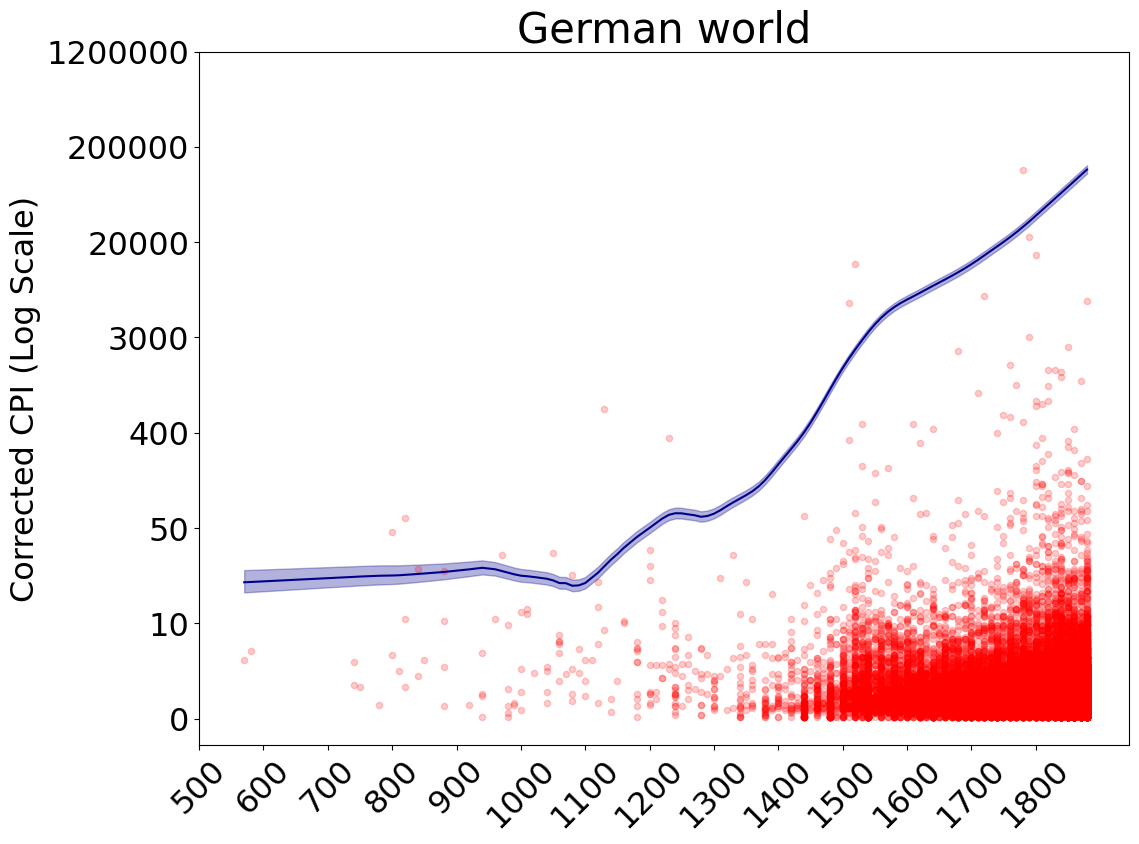

In [17]:
plot_figure(region_name = 'German world', min_year = 500, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False, frac=0.2,    
                fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

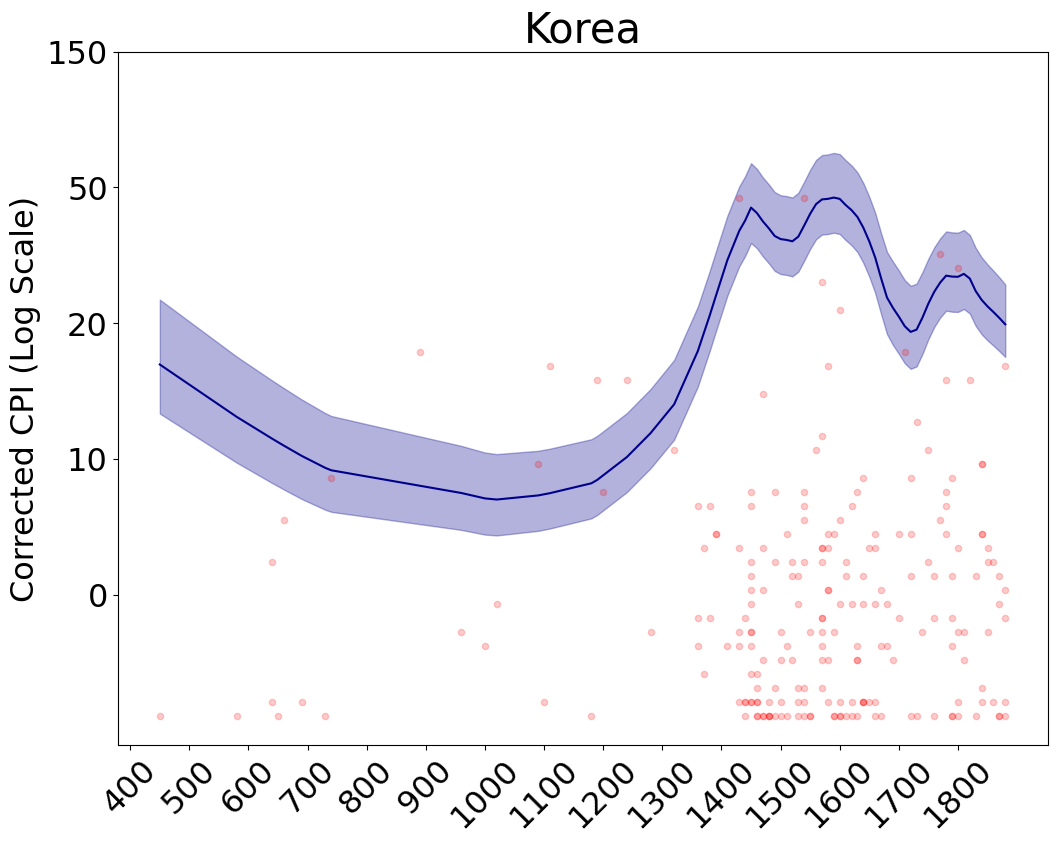

In [47]:
plot_figure(region_name = 'Korea', min_year = 400, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False, frac=0.2, fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

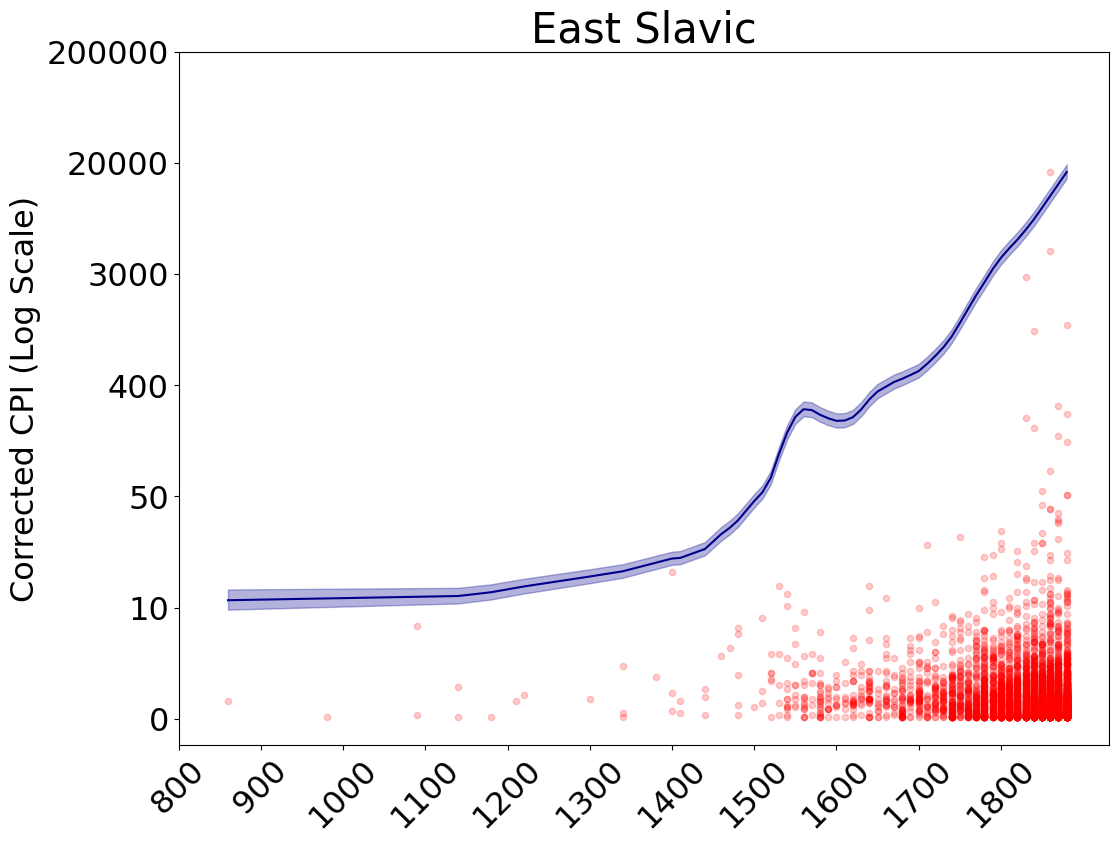

In [49]:
plot_figure(region_name = 'East Slavic', min_year = 800, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False, frac=0.2,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

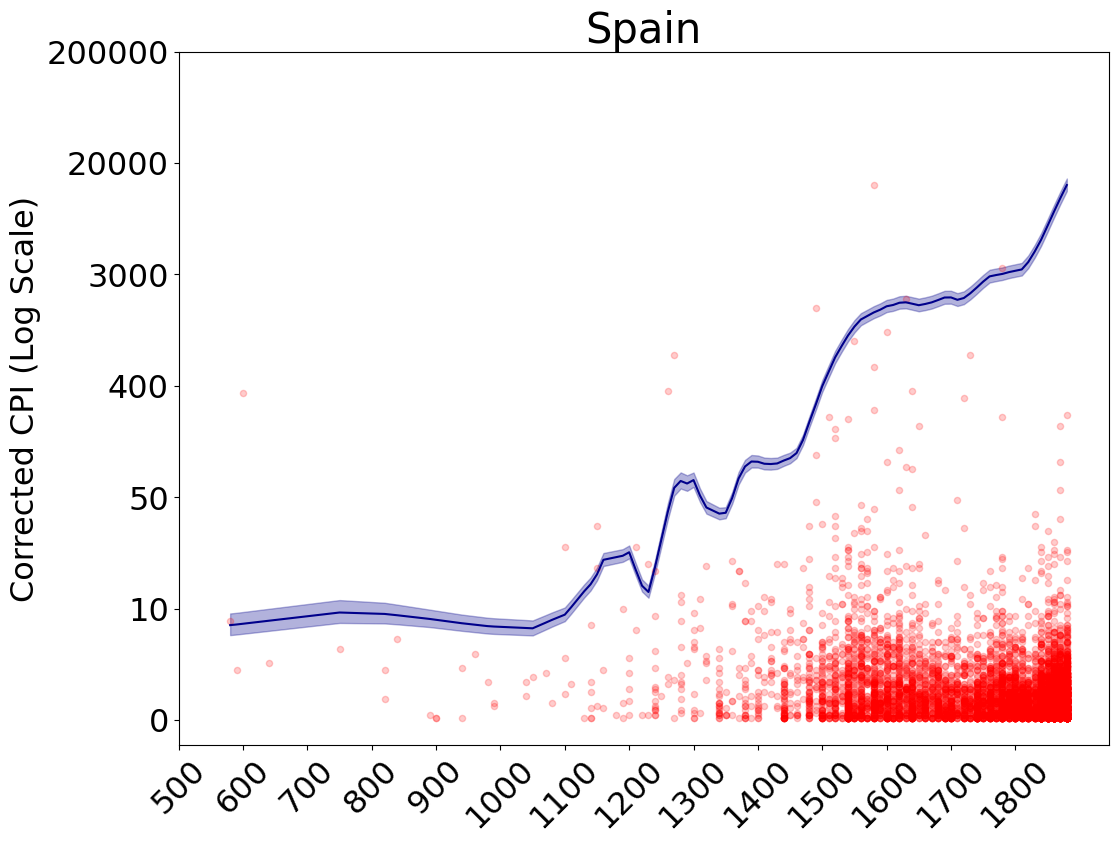

In [20]:
plot_figure(region_name = 'Spain', min_year = 500, max_year = 1880,period_data = None,  year_step = 100, 
            plot_original_trend = False, plot_name_names=False,
            fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

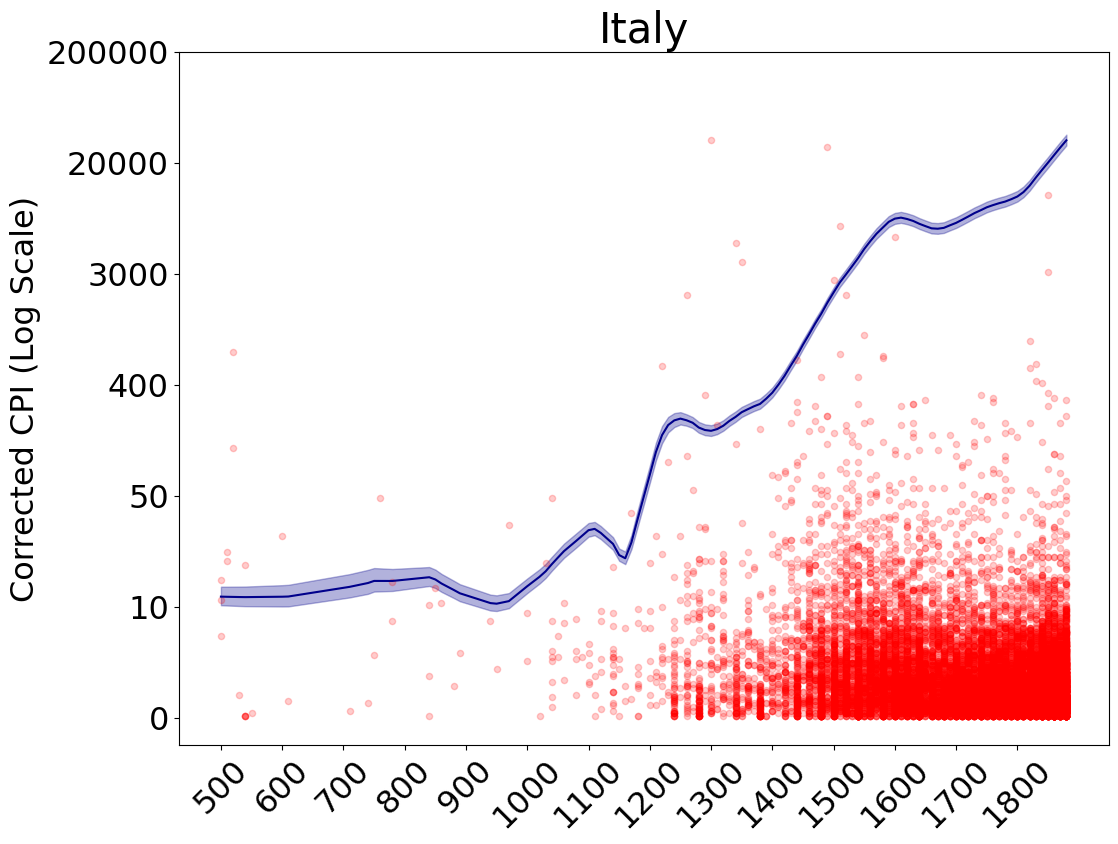

In [41]:
plot_figure(region_name = 'Italy', min_year = 500, max_year = 1880,
            period_data = None,  year_step = 100,  plot_original_trend = False, plot_name_names=False, 
            fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

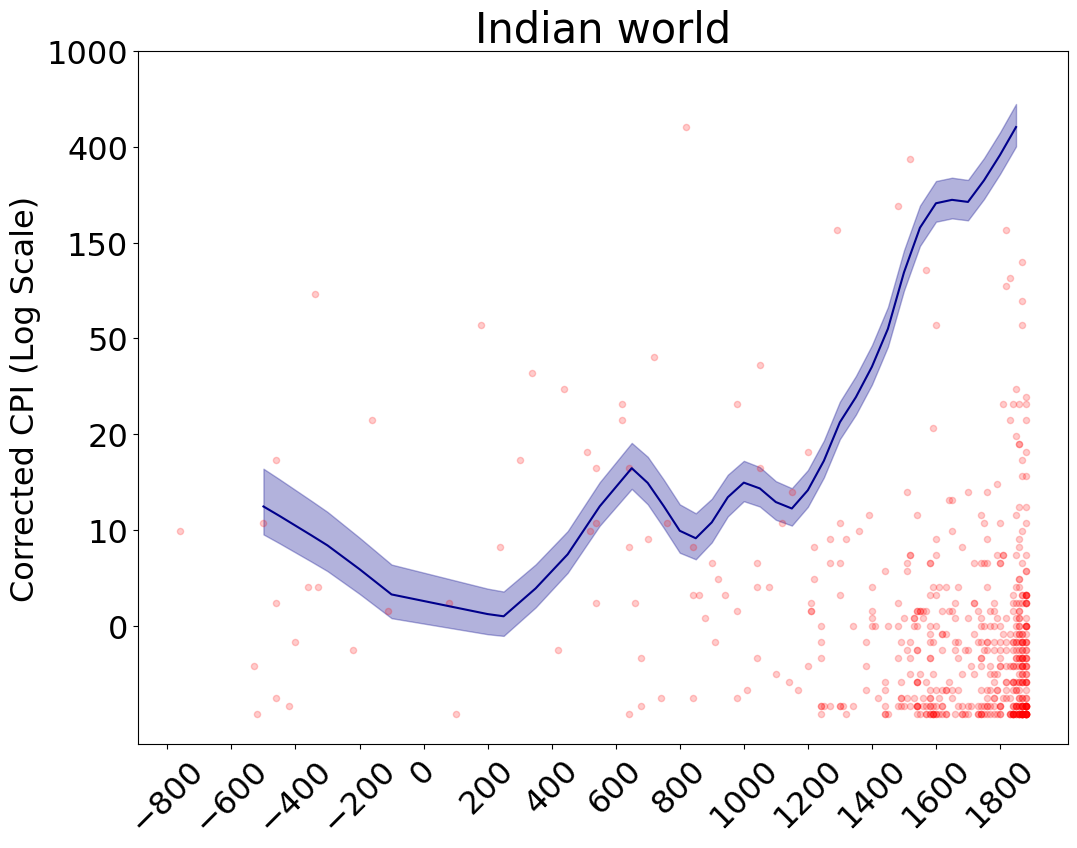

In [22]:
plot_figure(region_name = 'Indian world', min_year = -800, max_year = 1880,
            period_data = None,  fifty = True, year_step = 200, 
            plot_original_trend = False, frac=0.2,plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

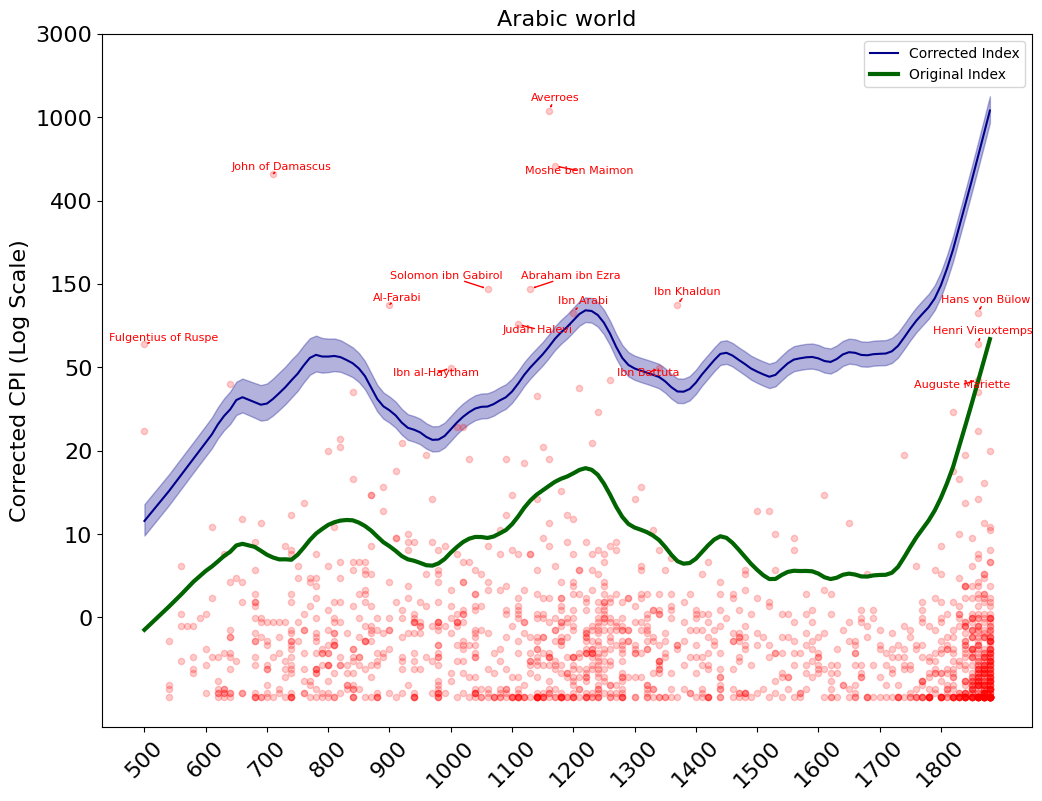

In [23]:
plot_figure(region_name = 'Arabic world', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = True)

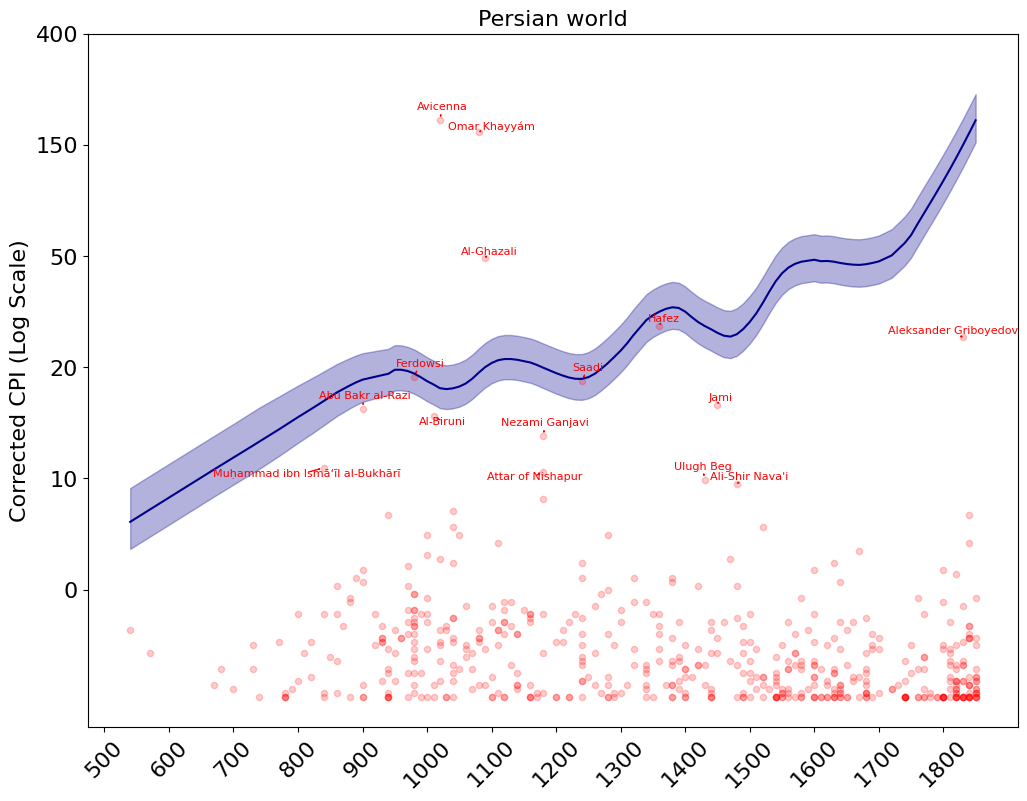

In [24]:
plot_figure(region_name = 'Persian world', min_year = 500, max_year = 1850,period_data = None,  year_step = 100, fifty=False, frac=0.2)

In [55]:
japanese_period_data = {
    "x_intercepts": [
        [0, 300],
        [300, 538],
        [538, 710],
        [710, 794],
        [794, 1185],
        [1185, 1333],
        [1333, 1600],
        [1600, 1800]
    ],
    "labels": [
        "Yayoi period",
        "Kofun period",
        "Asuka period",
        "Nara period",
        "Heian period",
        "Kamakura period",
        "Muromachi period",
        "Edo period"
    ]
}

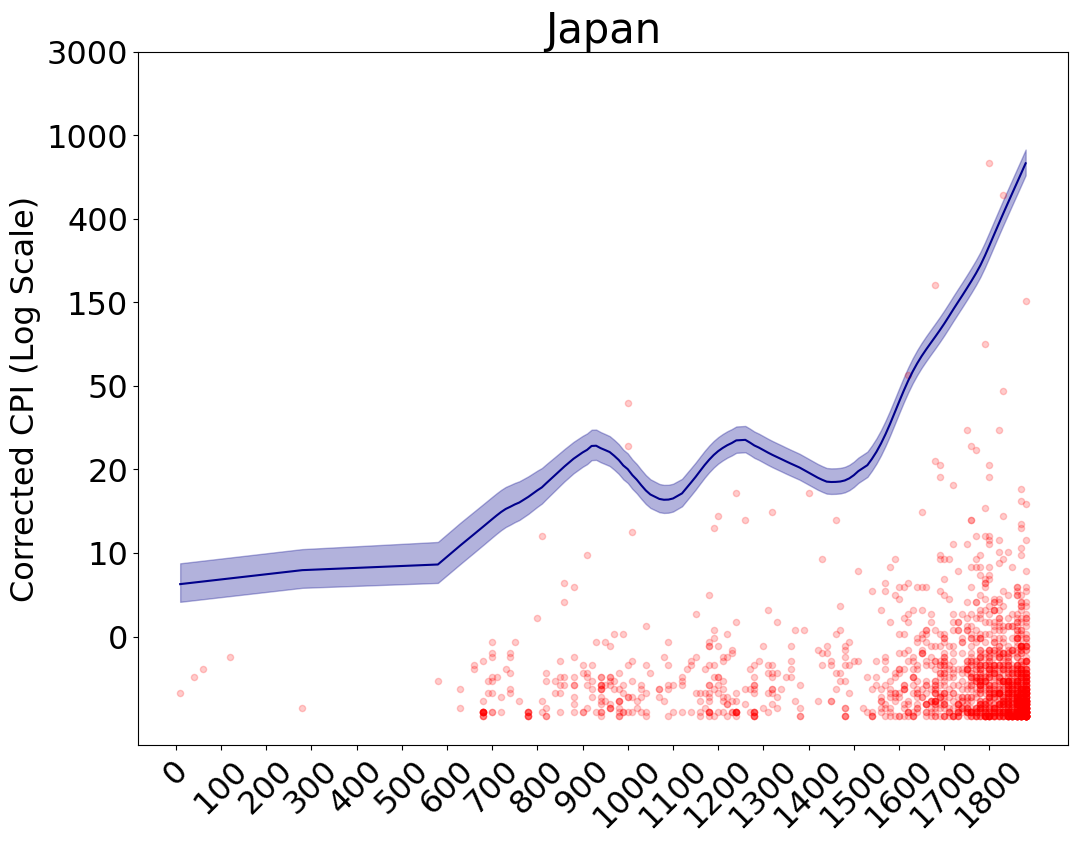

In [57]:
plot_figure(region_name = 'Japan', min_year = 0, max_year = 1880,period_data = None,  year_step = 100,  
            plot_original_trend = False, frac = 0.2, plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

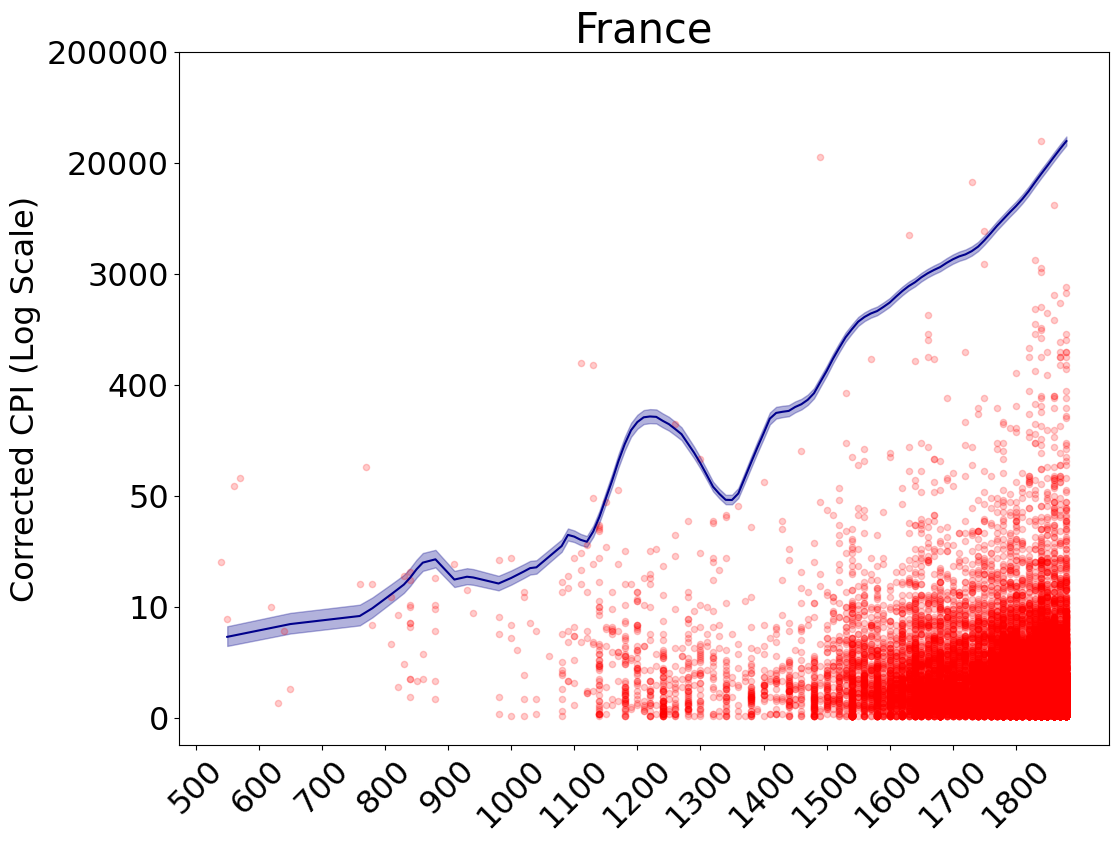

In [27]:
plot_figure(region_name = 'France', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  
            plot_original_trend = False, plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

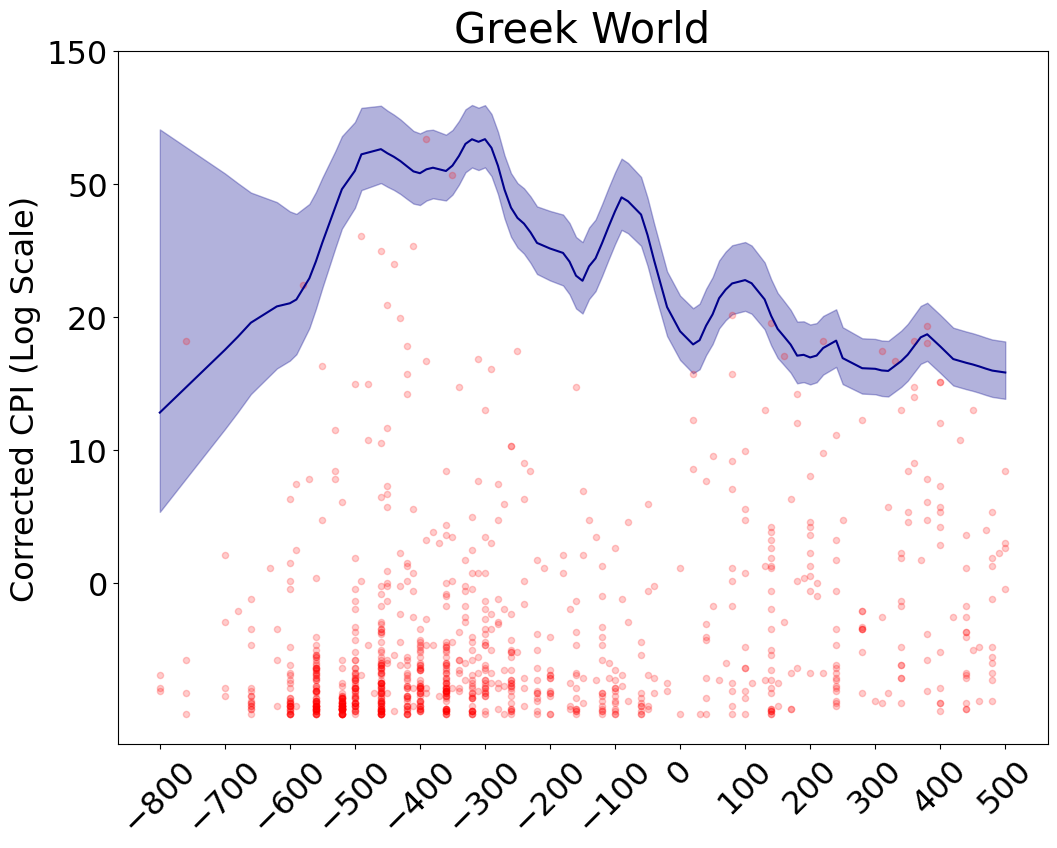

In [42]:
plot_figure(region_name = 'Greek World', min_year = -800, 
            max_year = 500,period_data = None,  year_step = 100, frac = 0.15,  
            plot_original_trend = False, plot_name_names = False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

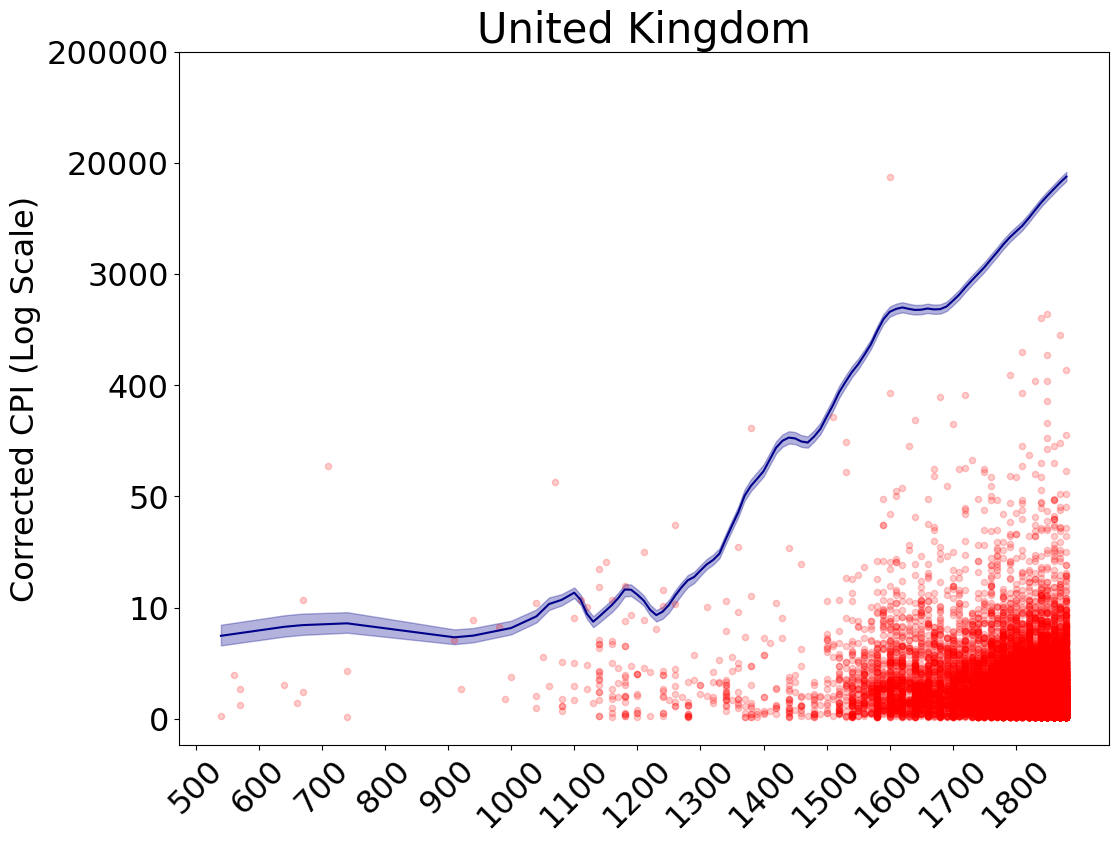

In [29]:
plot_figure(region_name = 'United Kingdom', min_year = 500, max_year = 1880,period_data = None,  year_step = 100,  plot_original_trend = False,
             plot_name_names=False,fontsize_title=30,
                fontsize_axis_ticks = 23,
                fontsize_axis_name = 23)

### Plot 2 figures

In [30]:
def plot_figures(region_name_1, 
                 region_name_2,
                    max_year, 
                    min_year, 
                    period_data, 
                    title,
                    year_step = 200, 
                    plot_names = True, 
                    frac = 0.1, 
                    top_n_individuals = 15,
                    plot_bars = False,
                    plot_original_trend = False,
                    fifty=False,
                    plot_name_names=True
                    ):




    
    df = df_cultura[df_cultura['region_name'].isin([region_name_1, region_name_2])]


    if fifty:
        df['decade'] = df['decade'].apply(lambda x: int(x) + (50 - int(x) % 50))
        df = df.groupby(['region_name', 'decade']).sum().reset_index()


    df = df[(df['decade'] <=max_year) & (df['decade']>=min_year)]

    df['N_est'] = np.log(df['N_est'])  # Applying log transformation
    df['N_est_min'] = np.log(df['N_est_min'])  # Min bound log
    df['N_est_max'] = np.log(df['N_est_max'])  # Max bound log
    df['score'] = np.log(df['score'])  # Max bound log



    df_individuals_filtered = df_individuals[(df_individuals['decade']<=max_year)&(df_individuals['decade']>=min_year)]
    df_individuals_filtered = df_individuals_filtered[df_individuals_filtered['region_name'].isin([region_name_1, region_name_2])]
    # Define your color scheme
    colors = {
        region_name_1: "#00bfc4",
        region_name_2: "#f8766d"
    }

    fig, ax = plt.subplots(figsize=(12, 9))


    # List for storing text annotations for later adjustment
    texts = []

    # Calculate the maximum smoothed value for normalization
    max_n_est = float('-inf')

    # Adding smoothing and plotting for each region
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        region_data.sort_values(by='decade', inplace=True)


        # LOESS smoothing
        smoothed = lowess(region_data['N_est'], region_data['decade'], frac=frac)
        smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=frac)
        smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=frac)

        # Update maximum n_est if current is higher
        max_n_est = max(max_n_est, max(smoothed[:, 1]))

        # Plotting the smoothed mean estimate
        ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region])

        # Plotting the confidence interval as a fill between
        ax.fill_between(smoothed[:, 0], smoothed_min[:, 1], smoothed_max[:, 1], color=colors[region], alpha=0.3)

    # Calculate the maximum score for all individuals for normalization
    max_global_score = df_individuals_filtered['score'].max()


    if plot_original_trend:

            # Adding smoothing and plotting for each region
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)

                    # LOESS smoothing
            smoothed = lowess(region_data['score'], region_data['decade'], frac=frac)
            # smoothed_min = lowess(region_data['N_est_min'], region_data['decade'], frac=0.2)
            # smoothed_max = lowess(region_data['N_est_max'], region_data['decade'], frac=0.2)

            # Update maximum n_est if current is higher
            max_n_est = max(max_n_est, max(smoothed[:, 1]))

            # Plotting the smoothed mean estimate
            ax.plot(smoothed[:, 0], smoothed[:, 1], label=region, color=colors[region], linewidth = 3,linestyle='-')


    if plot_names:
        # Collect texts from each region separately and adjust
        for region in df_individuals_filtered['region_name'].unique():
            region_individuals = df_individuals_filtered[df_individuals_filtered['region_name'] == region]
            region_individuals = region_individuals.sort_values('score', ascending=False)
            top_individuals = region_individuals.head(top_n_individuals).sort_values('score', ascending=False)
            texts = []  # Initialize a new list for this region's texts

            # Plot scatter for all individuals
            all_scores_normalized = (region_individuals['score'] / max_global_score) * max_n_est
            ax.scatter(region_individuals['decade'], all_scores_normalized, color=colors[region], alpha=0.2, s=20)

            if plot_name_names:
                # Texts for top 15
                for _, row in top_individuals.iterrows():
                    score_normalized = (row['score'] / max_global_score) * max_n_est
                    text = ax.text(row['decade'], score_normalized, row['individual_name'], 
                                ha='center', va='bottom', color=colors[region],fontsize=8)
                    texts.append(text)

                # Use adjust_text for the current region with the corresponding arrow color
                adjust_text(texts, arrowprops=dict(arrowstyle="->", color=colors[region]))

    

    if period_data:
        # Adding labels and vertical lines for each period
        for intercept, label in zip(period_data['x_intercepts'], period_data['labels']):
            start, end = intercept
            midpoint = (start + end) / 2  # Calculate the midpoint of each period
            
            # Add vertical line at the start of each period
            ax.axvline(x=start, color='lightgrey', linestyle='dotted', linewidth=2)
            
            # Add text label at the midpoint of the period, shifted upwards
            ax.text(midpoint, ax.get_ylim()[1] * 0.7, label, rotation=90, verticalalignment='center', fontsize=10, color='grey')



    if plot_bars:
        # Plot bars from the real values
        for region in df['region_name'].unique():
            region_data = df[df['region_name'] == region]
            region_data.sort_values(by='decade', inplace=True)
            # Bars representing the scores
            ax.bar(region_data['decade'], region_data['N_est'], label=region, color=colors[region], width=10, alpha = 0.2, zorder=2)


    # # Define specific y-ticks and convert them to log scale for plotting
    # yticks = [5, 10, 50, 100, 500, 1000, 2000]
    # yticks_log = np.log(yticks)  # Convert yticks to their logarithmic values

    # ax.set_yticks(yticks_log)  # Set the logarithmic y-ticks
    # ax.set_yticklabels([str(y) for y in yticks])  # Use original y-tick labels


     # Get current y-axis ticks (which are in log scale)
    ticks_log = ax.get_yticks()

    # Calculate the original values from the log scale ticks
    ticks_original = np.exp(ticks_log)  # Adjust if a different base is used for logging

    # Round to the nearest 10

    ticks_rounded = [custom_round(tick) for tick in ticks_original]

    #ticks_rounded = np.around(ticks_original / 10) * 10

    # Remove duplicates, keeping only the last occurrence
    unique_ticks = {}
    for tick, original in zip(ticks_rounded, ticks_log):
        unique_ticks[tick] = original  # This will overwrite the tick with its last occurrence

    # Now, set the ticks and labels, skipping duplicates
    final_ticks = sorted(unique_ticks.items())  # Sort ticks by their values
    ax.set_yticks([item[1] for item in final_ticks])  # Set the unique tick positions
    ax.set_yticklabels(['{:.0f}'.format(item[0]) for item in final_ticks])  # Set the unique tick labels



    # Set the size of x-axis and y-axis tick labels
    ax.tick_params(axis='x', labelsize=14)  # Increase x-axis tick label size
    ax.tick_params(axis='y', labelsize=14)  # Increase y-axis tick label size

    ax.set_xticks(np.arange(min_year, max_year + 1, year_step))  # Set x-ticks every 200 years
    # Rotating x-ticks by 45 degrees for better readability
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel('')
    ax.set_ylabel('Corrected CPI (Log Scale)', fontsize = 16)
    ax.set_title(title, fontsize = 16)
    ax.legend()
    plt.show()





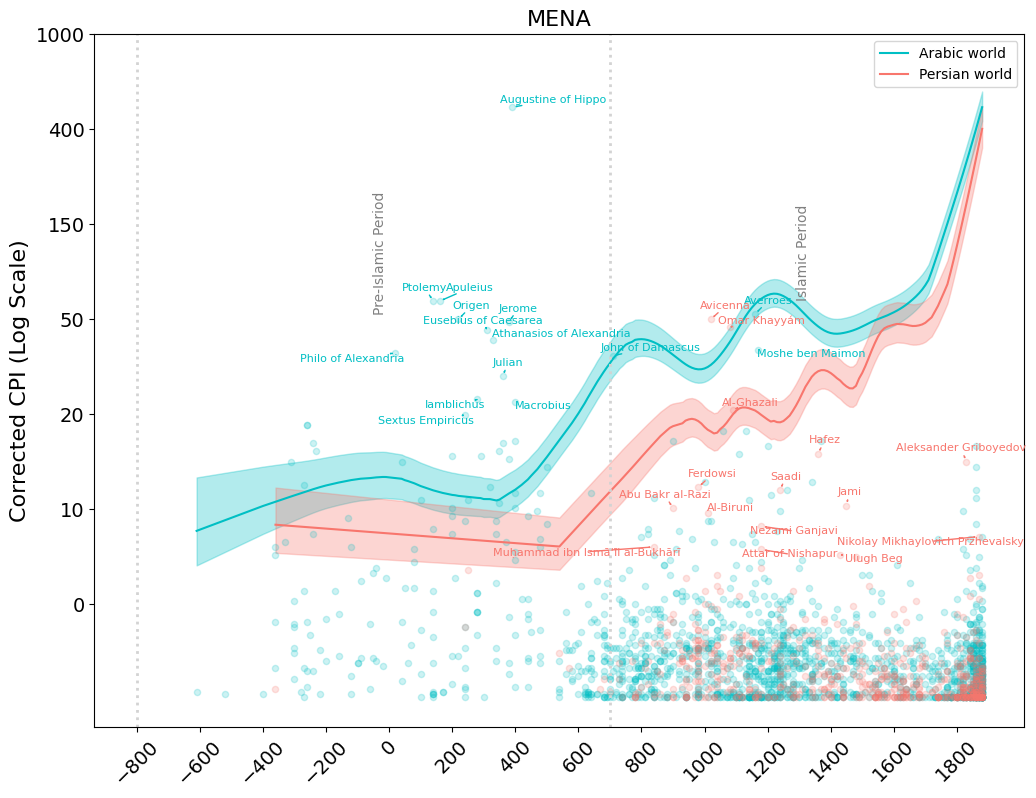

In [31]:

plot_figures(region_name_1="Arabic world", 
        region_name_2='Persian world',
            max_year = 1880, 
            min_year = -800, 
            title='MENA',
            period_data = {
            "x_intercepts": [
                [-800, 700],
                [700, 1880],
            
            ],
            "labels": [
                "Pre-Islamic Period",
                "Islamic Period",
            ]
        }, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False,
            fifty=False,
            plot_name_names=True)

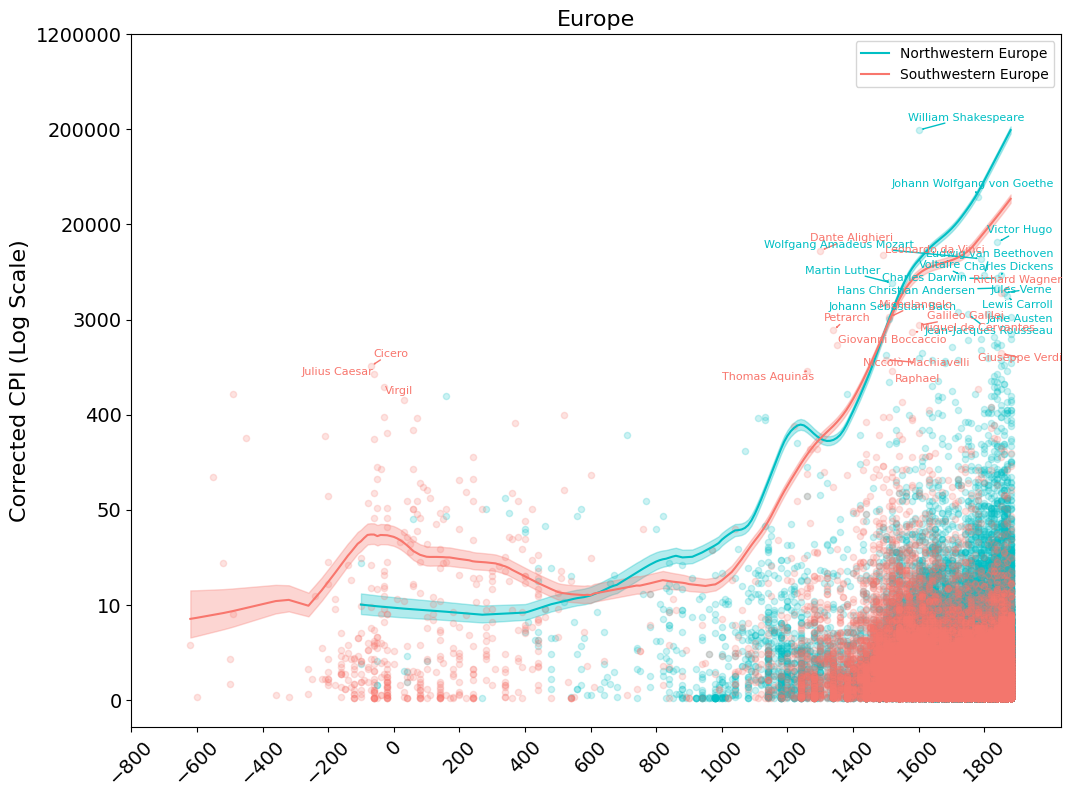

In [32]:
plot_figures(region_name_1="Northwestern Europe", 
        region_name_2='Southwestern Europe',
            max_year = 1880, 
            min_year = -800, 
            title='Europe',
            period_data = None, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.15, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, fifty = False)

In [33]:
list(set(df_cultura.region_name))

['East Slavic',
 'MENA',
 'Nordic countries',
 'Northern Japan',
 'United Kingdom',
 'Greek World',
 'Italy',
 'Persian world',
 'Southern Japan',
 'Spain',
 'Arabic world',
 'Latin World',
 'Portugal',
 'Southwestern Europe',
 'Northern China',
 'France',
 'Japan',
 'Northwestern Europe',
 'Indian world',
 'Central Europe',
 'German world',
 'Other',
 'Low countries',
 'Chinese world',
 'Korea',
 'Southern China']

In [34]:
list(set(df_cultura.region_name))

['East Slavic',
 'MENA',
 'Nordic countries',
 'Northern Japan',
 'United Kingdom',
 'Greek World',
 'Italy',
 'Persian world',
 'Southern Japan',
 'Spain',
 'Arabic world',
 'Latin World',
 'Portugal',
 'Southwestern Europe',
 'Northern China',
 'France',
 'Japan',
 'Northwestern Europe',
 'Indian world',
 'Central Europe',
 'German world',
 'Other',
 'Low countries',
 'Chinese world',
 'Korea',
 'Southern China']

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

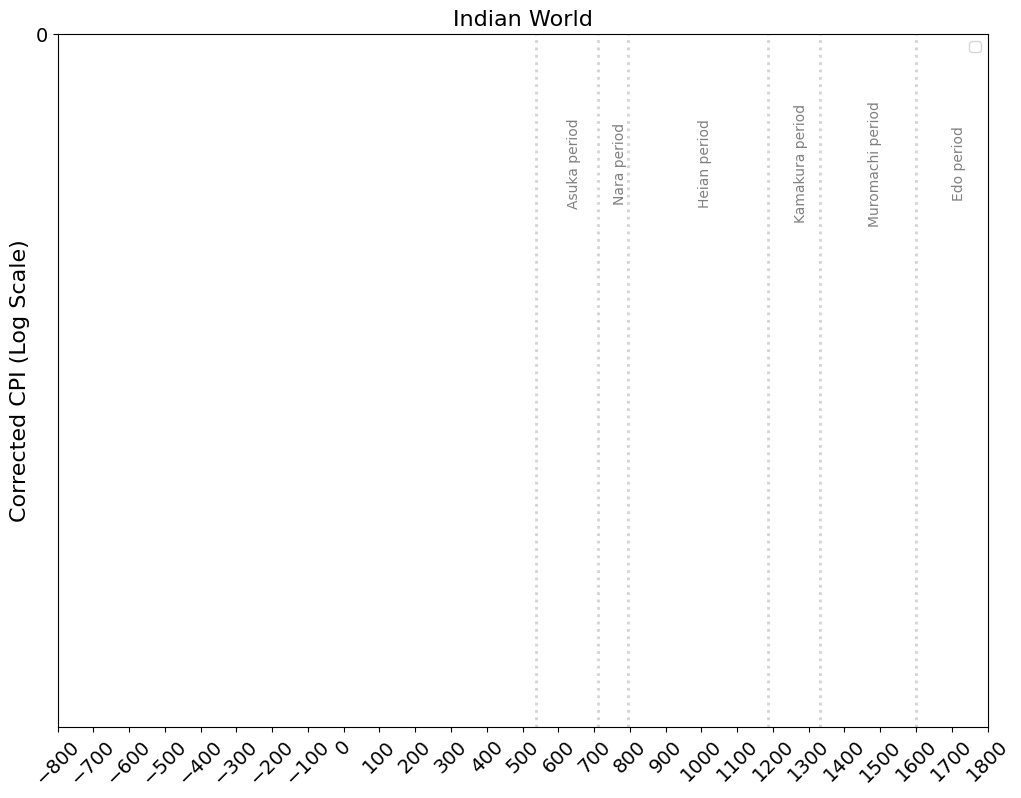

In [35]:
plot_figures(region_name_1="Southern India", 
        region_name_2="Northern India",
            max_year = 1880,
            min_year = -800, 
            title='Indian World',
            period_data =japanese_period_data, 
            year_step = 100, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = False)

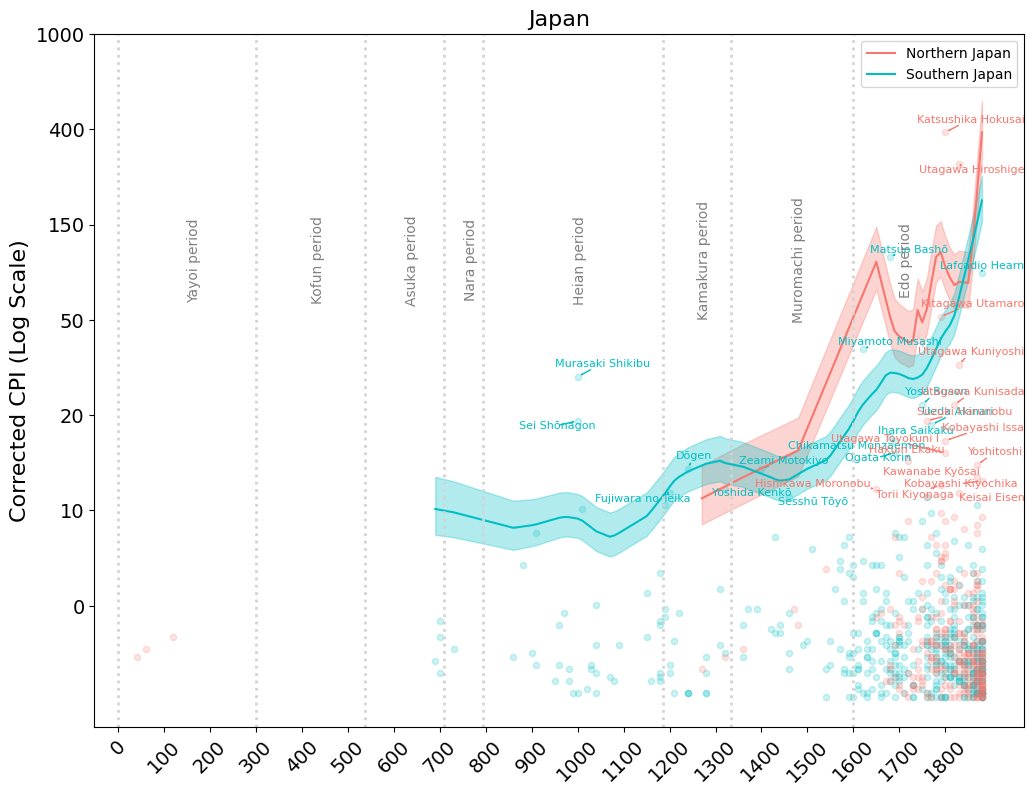

In [58]:
plot_figures(region_name_1="Southern Japan", 
        region_name_2="Northern Japan",
            max_year = 1880,
            min_year = 0, 
            title='Japan',
            period_data =japanese_period_data, 
            year_step = 100, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = False)

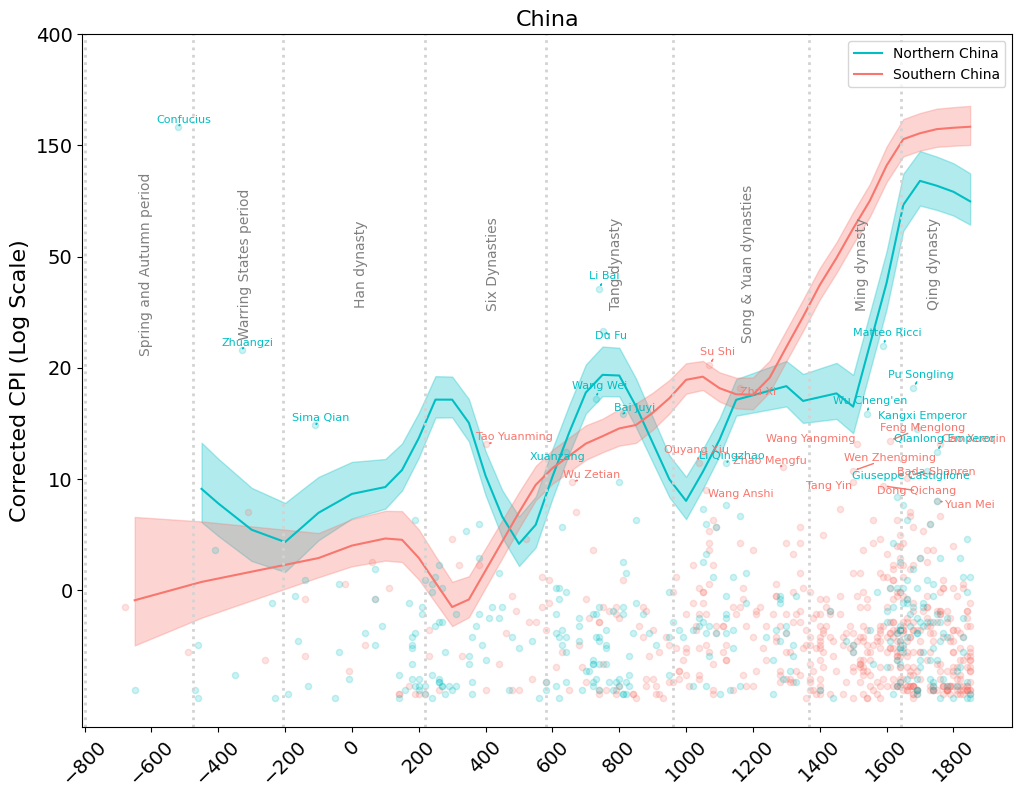

In [37]:
plot_figures(region_name_1="Northern China", 
        region_name_2='Southern China',
            max_year = 1850, 
            min_year = -800, 
            title='China',
            period_data =chinese_period_data, 
            year_step = 200, 
            plot_names = True, 
            frac = 0.2, 
            top_n_individuals = 15,
            plot_bars = False,
            plot_original_trend = False, 
            fifty = True)

In [38]:
list(set(df_cultura.region_name))

['East Slavic',
 'MENA',
 'Nordic countries',
 'Northern Japan',
 'United Kingdom',
 'Greek World',
 'Italy',
 'Persian world',
 'Southern Japan',
 'Spain',
 'Arabic world',
 'Latin World',
 'Portugal',
 'Southwestern Europe',
 'Northern China',
 'France',
 'Japan',
 'Northwestern Europe',
 'Indian world',
 'Central Europe',
 'German world',
 'Other',
 'Low countries',
 'Chinese world',
 'Korea',
 'Southern China']

### Plot Western Europe

In [39]:
plot = False

if plot:

    from dotenv import load_dotenv
    import sqlite3
    import os

    load_dotenv()

    DB_PATH = os.getenv("DB_PATH")

    conn = sqlite3.connect(DB_PATH)
    cursor = conn.cursor()

    df_western = df_cultura_original.copy()

    df_country = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
    df_country = df_country[df_country['country_name'].isin(['Tunisia', 'Morocco', 'Algeria'])]
    df_country = df_country[df_country['birthyear']<=535]

    df_western = df_western[~df_western['individual_wikidata_id'].isin(list(df_country['individual_wikidata_id']))]


    # remove individuals belonging to #before 500 to Tunisia, Morocco and Algeria

    df_western['N_est'] = df_western['f0'] + df_western['f1'] + df_western['f2']# plus the individual
    df_western['N_est_min']  =  df_western['min_f0'] + df_western['f1'] + df_western['f2']# plus the individual
    df_western['N_est_max']  =  df_western['max_f0'] + df_western['f1'] + df_western['f2']# plus the individual

    df_cultura = df_western.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'N_est_min':'sum', 'N_est_max':'sum', 'individual_wikidata_id':'count'}).reset_index()
    df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})

    # Load individuals Data
    df_individuals = pd.read_csv('/Users/charlesdedampierre/Desktop/cultura_project/immaterial_index/results/df_individuals_score.csv', index_col = [0])


    # Add indiviudals not taken into account into the unseen-species model
    df_works = pd.read_csv('db_extract/df_indi__work>2.csv', index_col=[0])
    df_works = df_works.groupby(['decade', 'region_name'])['individual_wikidata_id'].count().reset_index()
    df_works = df_works.rename(columns = {'individual_wikidata_id':'f>3'})

    df_cultura = pd.merge(df_cultura, df_works, on = ['region_name', 'decade'], how='left')
    df_cultura = df_cultura.fillna(0)


    df_cultura['N_est'] = df_cultura['N_est'] + df_cultura['f>3']
    df_cultura['N_est_min'] = df_cultura['N_est_min'] + df_cultura['f>3']
    df_cultura['N_est_max'] = df_cultura['N_est_max'] + df_cultura['f>3']
    df_cultura['score'] = df_cultura['score'] + df_cultura['f>3']



    regions_eu = ['Latin World',
    'Portugal',
    'Italy',
    #  'Greek World',
    'Spain',
    'Nordic countries',
    'German world',
    'Low countries',
    'France',
    'United Kingdom']

    df_cultura = df_cultura[df_cultura['region_name'].isin(regions_eu)]
    df_cultura['region_name'] = 'Western Europe'

    plot_figure(region_name = 'Western Europe', min_year = -800, max_year = 1850, period_data = None,  year_step = 100,  plot_original_trend = False, fifty=True)

In [40]:
# or just add Italy, France

# British Islands (After 500 CE)
# France (After 500 CE)
# German world (After 500 CE)
# Portugal (After 500 CE)
# Spain (after 500 CE)
# Italy (after 500 CE)
# Low countries (After 500 CE)
# Nordic countries (After 500 CE)